In [1]:
import numpy as np
import os
import h5py

In [2]:
SHAPENET_PATH = '/work_dir/diffusion-point-cloud/data/shapenet.hdf5'
if os.path.exists(SHAPENET_PATH):
    print("File exists.")
else:
    print("File does not exist.")

synsetid_to_cate = {
    '02691156': 'airplane', '02773838': 'bag', '02801938': 'basket',
    '02808440': 'bathtub', '02818832': 'bed', '02828884': 'bench',
    '02876657': 'bottle', '02880940': 'bowl', '02924116': 'bus',
    '02933112': 'cabinet', '02747177': 'can', '02942699': 'camera',
    '02954340': 'cap', '02958343': 'car', '03001627': 'chair',
    '03046257': 'clock', '03207941': 'dishwasher', '03211117': 'monitor',
    '04379243': 'table', '04401088': 'telephone', '02946921': 'tin_can',
    '04460130': 'tower', '04468005': 'train', '03085013': 'keyboard',
    '03261776': 'earphone', '03325088': 'faucet', '03337140': 'file',
    '03467517': 'guitar', '03513137': 'helmet', '03593526': 'jar',
    '03624134': 'knife', '03636649': 'lamp', '03642806': 'laptop',
    '03691459': 'speaker', '03710193': 'mailbox', '03759954': 'microphone',
    '03761084': 'microwave', '03790512': 'motorcycle', '03797390': 'mug',
    '03928116': 'piano', '03938244': 'pillow', '03948459': 'pistol',
    '03991062': 'pot', '04004475': 'printer', '04074963': 'remote_control',
    '04090263': 'rifle', '04099429': 'rocket', '04225987': 'skateboard',
    '04256520': 'sofa', '04330267': 'stove', '04530566': 'vessel',
    '04554684': 'washer', '02992529': 'cellphone',
    '02843684': 'birdhouse', '02871439': 'bookshelf',
    # '02858304': 'boat', no boat in our dataset, merged into vessels
    # '02834778': 'bicycle', not in our taxonomy
}
cate_to_synsetid = {v: k for k, v in synsetid_to_cate.items()}

File exists.


In [3]:
def hdf5_to_dict(hdf5_group):
    """
    Recursively convert hdf5 groups and datasets into a nested dictionary.
    
    Parameters:
    hdf5_group (h5py._hl.group.Group or h5py._hl.files.File): The HDF5 group (or file, which is also a group).

    Returns:
    dict: A nested dictionary where each key is the name of a group or dataset, and values are nested dictionaries or numpy arrays.
    """
    result = {}
    for key in hdf5_group.keys():
        item = hdf5_group[key]
        if isinstance(item, h5py.Dataset):  # Check if it is a dataset
            result[key] = item[()]  # Load the dataset contents into a numpy array
        elif isinstance(item, h5py.Group):  # Check if it is a group
            result[key] = hdf5_to_dict(item)  # Recursively convert the group
    return result

# Open the HDF5 file
with h5py.File(SHAPENET_PATH, 'r') as file:
    # Print the top-level categories
    print("Top-level keys/groups: ", list(file.keys()))

    shapenet = hdf5_to_dict(file)

shapenet_remapped = {}
for key, item in shapenet.items():
    shapenet_remapped[synsetid_to_cate[key]] = item
shapenet = shapenet_remapped

Top-level keys/groups:  ['02691156', '02747177', '02773838', '02801938', '02808440', '02818832', '02828884', '02843684', '02871439', '02876657', '02880940', '02924116', '02933112', '02942699', '02946921', '02954340', '02958343', '02992529', '03001627', '03046257', '03085013', '03207941', '03211117', '03261776', '03325088', '03337140', '03467517', '03513137', '03593526', '03624134', '03636649', '03642806', '03691459', '03710193', '03759954', '03761084', '03790512', '03797390', '03928116', '03938244', '03948459', '03991062', '04004475', '04074963', '04090263', '04099429', '04225987', '04256520', '04330267', '04379243', '04401088', '04460130', '04468005', '04530566', '04554684']


In [17]:
shapenet['airplane']['val'].shape[0] + shapenet['airplane']['val'].shape[0] + shapenet['airplane']['test'].shape[0]

1821

In [59]:
np.std(shapenet['airplane']['train'][0][:,2])

0.14088014

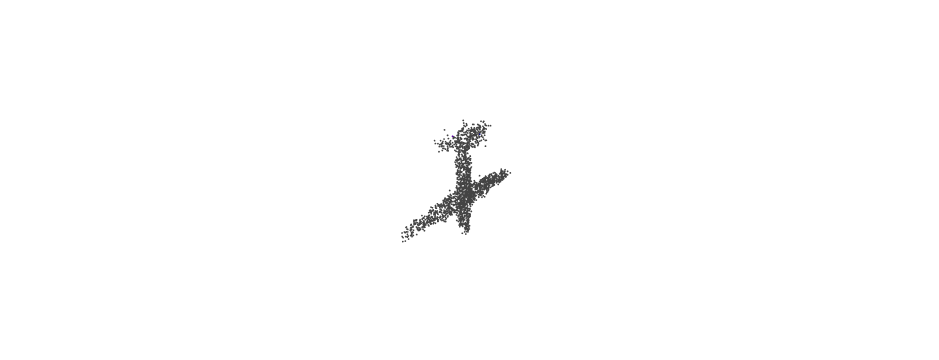

In [13]:
import os
import plotly.graph_objects as go
import sys
import torch
import numpy as np
import random

sys.path.append('/work_dir/diffusion-point-cloud')
from models.vae_gaussian import *
from models.vae_flow import *

device='cuda' if torch.cuda.is_available() else 'cpu'

def seed_all(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def normalize_point_clouds(pcs,mode):
    if mode is None:
        return pcs
    for i in range(pcs.size(0)):
        pc = pcs[i]
        if mode == 'shape_unit':
            shift = pc.mean(dim=0).reshape(1, 3)
            scale = pc.flatten().std().reshape(1, 1)
        elif mode == 'shape_bbox':
            pc_max, _ = pc.max(dim=0, keepdim=True) # (1, 3)
            pc_min, _ = pc.min(dim=0, keepdim=True) # (1, 3)
            shift = ((pc_min + pc_max) / 2).view(1, 3)
            scale = (pc_max - pc_min).max().reshape(1, 1) / 2
        pc = (pc - shift) / scale
        pcs[i] = pc
    return pcs

def predict(Seed,ckpt):
  if Seed==None:
    Seed=777 
  seed_all(Seed)
  ckpt = torch.load(ckpt)
  if ckpt['args'].model == 'gaussian':
      model = GaussianVAE(ckpt['args']).to(device)
  elif ckpt['args'].model == 'flow':
      model = FlowVAE(ckpt['args']).to(device)

  model.load_state_dict(ckpt['state_dict'])
  # Generate Point Clouds
  gen_pcs = []
  with torch.no_grad():
      z = torch.randn([1, ckpt['args'].latent_dim]).to(device)
      x = model.sample(z, 2048, flexibility=ckpt['args'].flexibility)
      gen_pcs.append(x.detach().cpu())
  gen_pcs = torch.cat(gen_pcs, dim=0)[:1]
  gen_pcs = normalize_point_clouds(gen_pcs, mode="shape_bbox")

  return gen_pcs[0]

def generate(seed,ckpt):

    colors=(238, 75, 43)
    points=predict(seed,ckpt)
    num_points=points.shape[0]


    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=points[:,0], y=points[:,1], z=points[:,2], 
                mode='markers',
                marker=dict(size=1, color=colors)
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()
    return points
    
ckpt = '/work_dir/diffusion-point-cloud/logs_gen/GEN_2024_04_13__16_26_53/ckpt_0.000000_81000.pt'
points = generate(500, ckpt)

In [12]:
points.shape

torch.Size([2048, 3])